# Interpretable Modelling of Credit Risk

>*Rakeen Rouf*
>
>*Bárbara Flores*


As detailed in Cynthia Rudin's excellent commentary on interpretability [(ArXiV version here)](https://arxiv.org/abs/1811.10154), there are a plethora of reasons to avoid the use of black box models when models are being used to make high stakes decisions to may have life-altering effects on real people. Efforts to develop "explainable black box models," while appealing for their potential to let us continuing using the same tools we always have and to creation explanations after the fact, are inherently flawed. As Rudin notes in my single favorite passage from her paper:

> Explainable ML methods provide explanations that are not faithful to what the original model computes. Explanations must be wrong. They cannot have perfect fidelity with respect to the original model. If the explanation was completely faithful to what the original model computes, the explanation would equal the original model, and one would not need the original model in the first place, only the explanation. (In other words, this is a case where the original model would be interpretable.) This leads to the danger that any explanation method for a black box model can be an inaccurate representation of the original model in parts of the feature space.
>
> An inaccurate (low-fidelity) explanation model limits trust in the explanation, and by extension, trust in the black box that it is trying to explain. An explainable model that has a 90% agreement with the original model indeed explains the original model most of the time. However, an explanation model that is correct 90% of the time is wrong 10% of the time. If a tenth of the explanations are incorrect, one cannot trust the explanations, and thus one cannot trust the original black box. If we cannot know for certain whether our explanation is correct, we cannot know whether to trust either the explanation or the original model.

With this motivation in mind, in this exercise, we will use a cutting edge interpretable modeling framework to model credit risk using data from the [14th Pacific-Asia Knowledge Discovery and Data Mining conference (PAKDD 2010)](https://pakdd.org/archive/pakdd2010/). This data covers the period of 2006 to 2009, and "comes from a private label credit card operation of a Brazilian credit company and its partner shops." (The competition was won by [TIMi](https://timi.eu/blog/news/timi-top-winner-at-the-pakdd-2010-cup/), who purely by coincidence helped me complete my PhD dissertation research!).

We will be working with Generalized Additive Models (GAMs) (not to be confused with Generalized *Linear* Models (GLMs) — GLMs are a special case of GAMs). In particular, we will be using the [pyGAM](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html), though this is far from the only GAM implementation out there. [mvgam](https://nicholasjclark.github.io/mvgam/) in R is probably considered the gold standard, as it was developed by a pioneering researcher of GAMs. `statsmodels` also has [an implementation](https://www.statsmodels.org/stable/gam.html), and GAM is also hiding in plain sight behind many other tools, like Meta's [Prophet](https://facebook.github.io/prophet/) time series forecasting library (which is GAM-based).

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

## Data Prep

### Exercise 1

The PADD 2010 data is in [this repository](https://github.com/nickeubank/MIDS_Data/tree/master/PAKDD%202010). You can find column names in `PAKDD2010_VariablesList.XLS` and the actual data in `PAKDD2010_Modeling_Data.txt`.

Note: you may run into a string-encoding issue loading the `PAKDD2010_Modeling_Data.txt` data. All I'll say is that most latin-based languages used `latin8` as a text encoding prior to broad adoption of UTF-8. (Don't know about UTF? [Check out this video](https://www.youtube.com/watch?v=MijmeoH9LT4)!)

Load the data (including column names).

In [2]:
VariablesList = [
    "ID_CLIENT",
    "CLERK_TYPE",
    "PAYMENT_DAY",
    "APPLICATION_SUBMISSION_TYPE",
    "QUANT_ADDITIONAL_CARDS",
    "POSTAL_ADDRESS_TYPE",
    "SEX",
    "MARITAL_STATUS",
    "QUANT_DEPENDANTS",
    "EDUCATION_LEVEL",
    "STATE_OF_BIRTH",
    "CITY_OF_BIRTH",
    "NACIONALITY",
    "RESIDENCIAL_STATE",
    "RESIDENCIAL_CITY",
    "RESIDENCIAL_BOROUGH",
    "FLAG_RESIDENCIAL_PHONE",
    "RESIDENCIAL_PHONE_AREA_CODE",
    "RESIDENCE_TYPE",
    "MONTHS_IN_RESIDENCE",
    "FLAG_MOBILE_PHONE",
    "FLAG_EMAIL",
    "PERSONAL_MONTHLY_INCOME",
    "OTHER_INCOMES",
    "FLAG_VISA",
    "FLAG_MASTERCARD",
    "FLAG_DINERS",
    "FLAG_AMERICAN_EXPRESS",
    "FLAG_OTHER_CARDS",
    "QUANT_BANKING_ACCOUNTS",
    "QUANT_SPECIAL_BANKING_ACCOUNTS",
    "PERSONAL_ASSETS_VALUE",
    "QUANT_CARS",
    "COMPANY",
    "PROFESSIONAL_STATE",
    "PROFESSIONAL_CITY",
    "PROFESSIONAL_BOROUGH",
    "FLAG_PROFESSIONAL_PHONE",
    "PROFESSIONAL_PHONE_AREA_CODE",
    "MONTHS_IN_THE_JOB",
    "PROFESSION_CODE",
    "OCCUPATION_TYPE",
    "MATE_PROFESSION_CODE",
    "MATE_EDUCATION_LEVEL",
    "FLAG_HOME_ADDRESS_DOCUMENT",
    "FLAG_RG",
    "FLAG_CPF",
    "FLAG_INCOME_PROOF",
    "PRODUCT",
    "FLAG_ACSP_RECORD",
    "AGE",
    "RESIDENCIAL_ZIP_3",
    "PROFESSIONAL_ZIP_3",
    "TARGET_LABEL_BAD=1",
]

Modeling_Data = pd.read_csv(
    "https://media.githubusercontent.com/media/nickeubank/MIDS_Data/master/PAKDD%202010/PAKDD2010_Modeling_Data.txt",
    sep="\t",
    header=None,
    names=VariablesList,
    index_col=None,
    encoding="latin8",
    low_memory=False,
)

Modeling_Data.head()

,ID_CLIENT,CLERK_TYPE,PAYMENT_DAY,APPLICATION_SUBMISSION_TYPE,QUANT_ADDITIONAL_CARDS,POSTAL_ADDRESS_TYPE,SEX,MARITAL_STATUS,QUANT_DEPENDANTS,EDUCATION_LEVEL,...,FLAG_HOME_ADDRESS_DOCUMENT,FLAG_RG,FLAG_CPF,FLAG_INCOME_PROOF,PRODUCT,FLAG_ACSP_RECORD,AGE,RESIDENCIAL_ZIP_3,PROFESSIONAL_ZIP_3,TARGET_LABEL_BAD=1
0,1,C,5,Web,0,1,F,6,1,0,...,0,0,0,0,1,N,32,595,595,1
1,2,C,15,Carga,0,1,F,2,0,0,...,0,0,0,0,1,N,34,230,230,1
2,3,C,5,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,27,591,591,0
3,4,C,20,Web,0,1,F,2,0,0,...,0,0,0,0,1,N,61,545,545,0
4,5,C,10,Web,0,1,M,2,0,0,...,0,0,0,0,1,N,48,235,235,1


### Exercise 2

There are a few variables with a lot of missing values (more than half missing). Given the limited documentation for this data it's a little hard to be sure why, but given the effect on sample size and what variables are missing, let's go ahead and drop them. You you end up dropping 6 variables.

Hint: Some variables have missing values that aren't immediately obviously.

(This is not strictly necessary at this stage, given we'll be doing more feature selection down the line, but keeps things easier knowing we don't have to worry about missingness later.)

In [3]:
Modeling_Data.shape

(50000, 54)

> First, we validate which variables have more than 25,000 records encoded as null. We can observe in the following summary that the variables `PROFESSIONAL_CITY`, `PROFESSIONAL_BOROUGH`, `MATE_PROFESSION_CODE`, and `MATE_EDUCATION_LEVEL` meet this condition.

In [4]:
Modeling_Data.isnull().sum().sort_values(ascending=False).head(10)

PROFESSIONAL_CITY                 33783
PROFESSIONAL_BOROUGH              33783
MATE_EDUCATION_LEVEL              32338
MATE_PROFESSION_CODE              28884
PROFESSION_CODE                    7756
OCCUPATION_TYPE                    7313
MONTHS_IN_RESIDENCE                3777
RESIDENCE_TYPE                     1349
PROFESSIONAL_PHONE_AREA_CODE          0
QUANT_SPECIAL_BANKING_ACCOUNTS        0
dtype: int64

>Later, upon visual inspection of the database, we noticed that the variables `EDUCATION_LEVEL`, `APPLICATION_SUBMISSION_TYPE`, `PROFESSIONAL_STATE`, and `PROFESSIONAL_PHONE_AREA_CODE` also appear to be problematic, which we will validate next.

In [5]:
Modeling_Data.groupby("EDUCATION_LEVEL").size().sort_values(ascending=False)

EDUCATION_LEVEL
0    50000
dtype: int64

In [6]:
Modeling_Data.groupby("APPLICATION_SUBMISSION_TYPE").size().sort_values(
    ascending=False
).head(5)

APPLICATION_SUBMISSION_TYPE
Web      28206
0        19461
Carga     2333
dtype: int64

In [7]:
Modeling_Data.groupby("PROFESSIONAL_PHONE_AREA_CODE").size().sort_values(
    ascending=False
).head(5)

PROFESSIONAL_PHONE_AREA_CODE
       36532
5       1457
54      1109
107      981
97       644
dtype: int64

In [8]:
Modeling_Data.groupby("PROFESSIONAL_STATE").size().sort_values(ascending=False).head(5)

PROFESSIONAL_STATE
      34307
SP     2400
RS     2092
CE     1420
BA     1387
dtype: int64

> Out of the 3 previously mentioned problematic variables, we observe that `PROFESSIONAL_STATE` and `PROFESSIONAL_PHONE_AREA_CODE` have more than 25,000 missing values. Additionally, `EDUCATION_LEVEL` presents the value 0 for all its data, while the encoding in the dictionary starts from 1. Therefore, our final list of variables to be removed, which have more than half missing values, includes `EDUCATION_LEVEL`, `PROFESSIONAL_CITY`, `PROFESSIONAL_BOROUGH`, `MATE_PROFESSION_CODE`, `MATE_EDUCATION_LEVEL`, `PROFESSIONAL_STATE`, and `PROFESSIONAL_PHONE_AREA_CODE`.

In [9]:
columns_to_drop = [
    "EDUCATION_LEVEL",
    "PROFESSIONAL_CITY",
    "PROFESSIONAL_BOROUGH",
    "MATE_PROFESSION_CODE",
    "MATE_EDUCATION_LEVEL",
    "PROFESSIONAL_STATE",
    "PROFESSIONAL_PHONE_AREA_CODE",
]

Modeling_Data = Modeling_Data.drop(columns_to_drop, axis=1)

### Exercise 3

Let's start off by fitting a model that uses the following variables:

```
"QUANT_DEPENDANTS",
"QUANT_CARS",
"MONTHS_IN_RESIDENCE",
"PERSONAL_MONTHLY_INCOME",
"QUANT_BANKING_ACCOUNTS",
"AGE",
"SEX",
"MARITAL_STATUS",
"OCCUPATION_TYPE",
"RESIDENCE_TYPE",
"RESIDENCIAL_STATE",
"RESIDENCIAL_CITY",
"RESIDENCIAL_BOROUGH",
"RESIDENCIAL_ZIP_3"
```

(GAMs don't have any automatic feature selection methods, so these are based on my own sense of features that are likely to matter. A fully analysis would entail a few passes at feature refinement)

Plot and otherwise characterize the distributions of all the variables we may use. If you see anything bananas, adjust how terms enter your model. Yes, pyGAM has flexible functional forms, but giving the model features that are engineered to be more substantively meaningful (e.g., taking log of income) will aid model estimation. 

You should probably do something about the functional form of *at least* `PERSONAL_MONTHLY_INCOME`, and `QUANT_DEPENDANTS`.

In [10]:
Modeling_Data = Modeling_Data[
    [
        "QUANT_DEPENDANTS",
        "QUANT_CARS",
        "MONTHS_IN_RESIDENCE",
        "PERSONAL_MONTHLY_INCOME",
        "QUANT_BANKING_ACCOUNTS",
        "AGE",
        "SEX",
        "MARITAL_STATUS",
        "OCCUPATION_TYPE",
        "RESIDENCE_TYPE",
        "RESIDENCIAL_STATE",
        "RESIDENCIAL_CITY",
        "RESIDENCIAL_BOROUGH",
        "RESIDENCIAL_ZIP_3",
        "TARGET_LABEL_BAD=1",
    ]
]

>Given the wide range of values taken by the variable `PERSONAL_MONTHLY_INCOME` and the fact that the variance increases as the level of the variable grows, we transform this variable by taking the logarithm, resulting in the creation of the variable `LOG_PERSONAL_MONTHLY_INCOME`.

In [11]:
# PERSONAL_MONTHLY_INCOME
Modeling_Data["LOG_PERSONAL_MONTHLY_INCOME"] = np.log(
    Modeling_Data["PERSONAL_MONTHLY_INCOME"]
)

>We can observe that in the variable `QUANT_DEPENDANTS`, there is an outlier with a value of 53 for `QUANT_DEPENDANTS`. Since there is only 1 record with this value, we have no problem in removing it.

In [12]:
# QUANT_DEPENDANTS
Modeling_Data.groupby("QUANT_DEPENDANTS").size().sort_index()

QUANT_DEPENDANTS
0     33655
1      7004
2      5363
3      2465
4       860
5       365
6       139
7        65
8        35
9        14
10       13
11        7
12        6
13        4
14        3
15        1
53        1
dtype: int64

In [13]:
Modeling_Data = Modeling_Data[Modeling_Data["QUANT_DEPENDANTS"] != 53]

>After the transformations mentioned earlier, we can observe the distribution of our numerical variables in the following histograms.

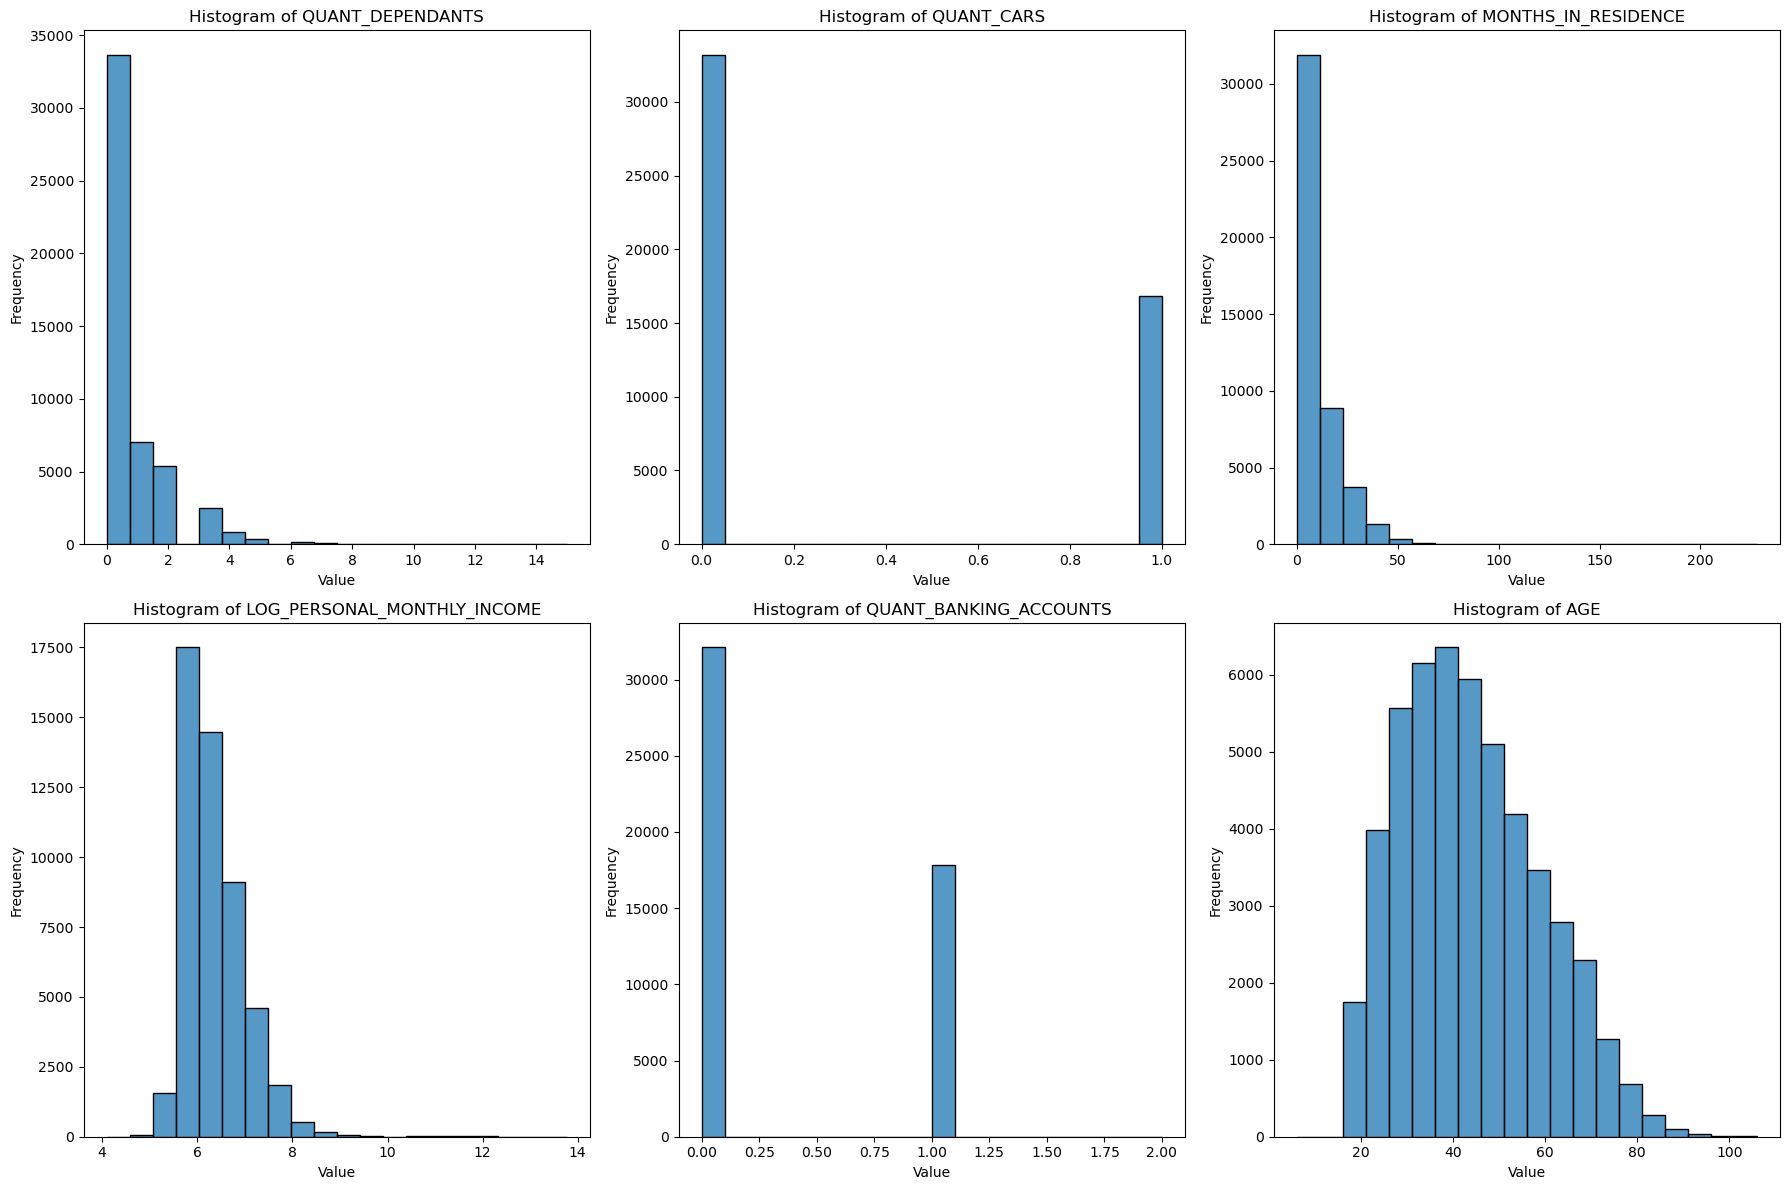

In [14]:
variables_num = [
    "QUANT_DEPENDANTS",
    "QUANT_CARS",
    "MONTHS_IN_RESIDENCE",
    "LOG_PERSONAL_MONTHLY_INCOME",
    "QUANT_BANKING_ACCOUNTS",
    "AGE",
]

plt.figure(figsize=(18, 12))

for i, variable in enumerate(variables_num, start=1):
    plt.subplot(2, 3, i)
    sns.histplot(data=Modeling_Data[variable], bins=20)
    plt.title(f"Histogram of {variable}")
    plt.xlabel("Value")
    plt.ylabel("Frequency")

plt.tight_layout()
plt.show()

> Similarly, we can observe the distribution of our categorical variables in the following bar plots.
>
>It is worth mentioning that some of these variables may not be as useful in their interpretation, as we find that the variables `MARITAL_STATUS`, `OCCUPATION_TYPE`, and `RESIDENCE_TYPE` are labeled as "Encoding not informed" in our dictionary. While we may encounter a model that informs us whether these variables are important or not, we will not be able to determine their true contribution to the model due to the lack of information about their encoding.

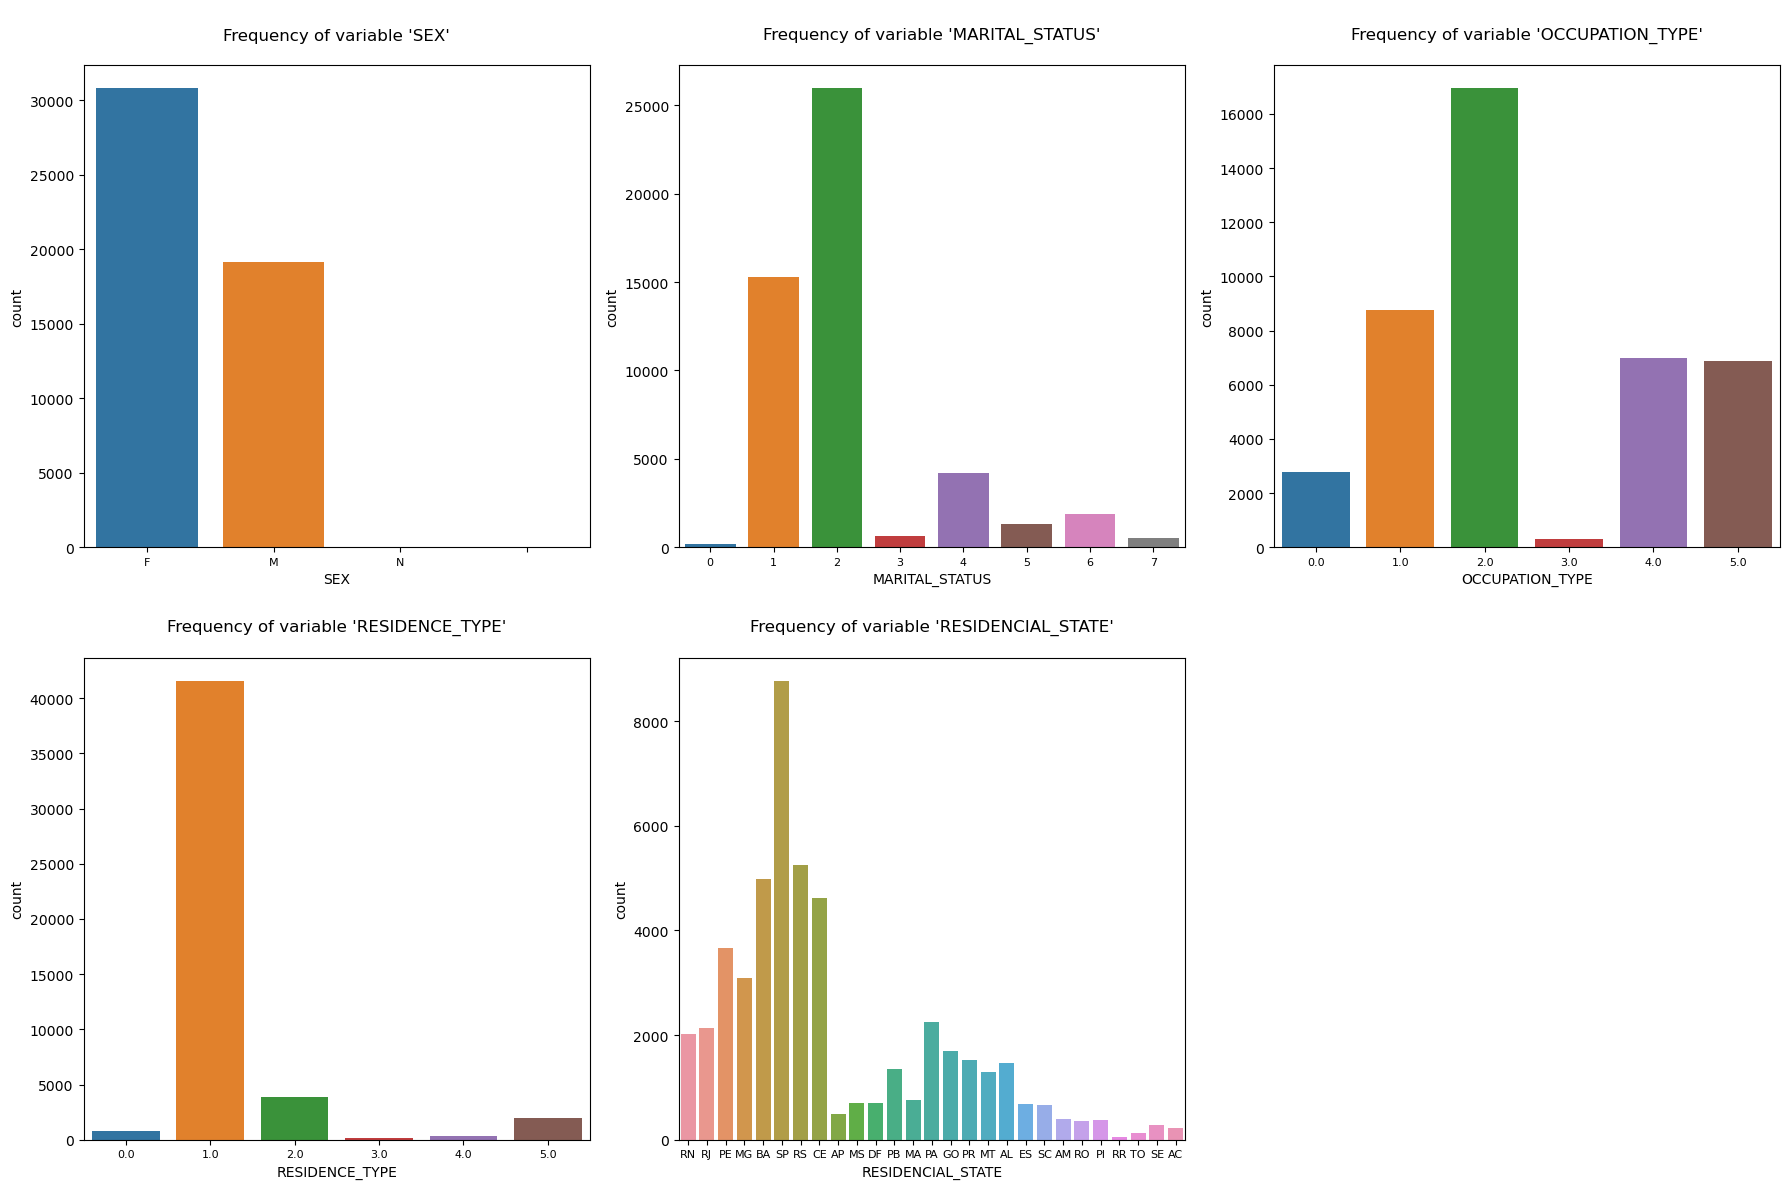

In [15]:
variables_cat = [
    "SEX",
    "MARITAL_STATUS",
    "OCCUPATION_TYPE",
    "RESIDENCE_TYPE",
    "RESIDENCIAL_STATE",
]

plt.figure(figsize=(18, 12))

for i, variable in enumerate(variables_cat, start=1):
    plt.subplot(2, 3, i)
    sns.countplot(data=Modeling_Data, x=variable)
    plt.title(f"\nFrequency of variable '{variables_cat[i - 1]}'\n")
    plt.xticks(fontsize=8)


plt.tight_layout()
plt.show()

> Finally, the categorical variables `RESIDENCIAL_CITY`, `RESIDENCIAL_BOROUGH`, and `RESIDENCIAL_ZIP_3` cannot be plotted because they have 3,529, 14,511, and 794 different unique categories respectively.

In [16]:
print(
    f"Number of unique categories in RESIDENCIAL_CITY: {Modeling_Data['RESIDENCIAL_CITY'].nunique():,}"
)
print(
    f"Number of unique categories in RESIDENCIAL_BOROUGH: {Modeling_Data['RESIDENCIAL_BOROUGH'].nunique():,}"
)
print(
    f"Number of unique categories in RESIDENCIAL_ZIP_3: {Modeling_Data['RESIDENCIAL_ZIP_3'].nunique():,}"
)

Number of unique categories in RESIDENCIAL_CITY: 3,529
Number of unique categories in RESIDENCIAL_BOROUGH: 14,511
Number of unique categories in RESIDENCIAL_ZIP_3: 794


### Exercise 4

Geographic segregation means residency data often contains LOTS of information. But there's a problem with `RESIDENCIAL_CITY` and `RESIDENCIAL_BOROUGH`. What is the problem?

In any real project, this would be something absolutely worth resolving, but for this exercise, we'll just drop all three string `RESIDENCIAL_` variables.

In [17]:
Modeling_Data["RESIDENCIAL_CITY"].nunique()

3529

In [18]:
Modeling_Data["RESIDENCIAL_BOROUGH"].nunique()

14511

In [19]:
Modeling_Data["RESIDENCIAL_ZIP_3"].nunique()

794

In [20]:
Modeling_Data = Modeling_Data[
    [
        "QUANT_DEPENDANTS",
        "QUANT_CARS",
        "MONTHS_IN_RESIDENCE",
        "PERSONAL_MONTHLY_INCOME",
        "QUANT_BANKING_ACCOUNTS",
        "AGE",
        "SEX",
        "MARITAL_STATUS",
        "OCCUPATION_TYPE",
        "RESIDENCE_TYPE",
        "RESIDENCIAL_STATE",
        "RESIDENCIAL_CITY",
        "RESIDENCIAL_BOROUGH",
        "RESIDENCIAL_ZIP_3",
        "TARGET_LABEL_BAD=1",
    ]
]

## Model Fitting

### Exercise 5

First, use `train_test_split` to do an 80/20 split of your data. Then, using the `TARGET_LABEL_BAD` variable, fit a classification model on this data. Optimize with `gridsearch`. Use splines for continuous variables and factors for categoricals.

At this point we'd *ideally* be working with 11 variables. However pyGAM can get a little slow with factor features with lots of values + lots of unique values (e.g., 50,000 observations and the *many* values of `RESIDENCIAL_ZIP` takes about 15 minutes on my computer). In that configuration, you should get a model fit in 10-15 seconds.

So let's start by fitting a model that also excludes `RESIDENCIAL_ZIP`.

### Exercise 6

Create a (naive) confusion matrix using the predicted values you get with `predict()` on your test data. Our stakeholder cares about two things: 

- maximizing the number of people to whom they extend credit, and
- the false negative rate (the share of people identified as "safe bets" who aren't, and who thus default).

How many "good bets" does the model predict (true negatives), and what is the [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives)?

Looking at the confusion matrix, how did the model maximize accuracy?

### Exercise 7

Suppose your stakeholder wants to minimize false negative rates. How low of a [False Omission Rate](https://en.wikipedia.org/wiki/False_omission_rate) (the share of predicted negatives that are false negatives) can you get (assuming more than, say, 10 true negatives), and how many "good bets" (true negatives) do they get at that risk level?

Hint: use `predict_proba()`

Note: One *can* use class weights to shift the emphasis of the original model fitting, but for the moment let's just play with `predict_proba()` and thresholds.

### Exercise 8

If the stakeholder wants to maximize true negatives and can tolerate a false omission rate of 19%, how many true negatives will they be able to enroll?

## Let's See This Interpretability!

We're using GAMs for their interpretability, so let's use it!

### Exercise 9


Plot the partial dependence plots for all your continuous factors with 95% confidence intervals (I have three, at this stage).

If you get an error like this when generating `partial_dependence` errors:

```python
----> pdep, confi = gam.partial_dependence(term=i, X=XX, width=0.95)

...
ValueError: X data is out of domain for categorical feature 4. Expected data on [1.0, 2.0], but found data on [0.0, 0.0]
```

it's because you have a variable set as a factor that doesn't have values of `0`. pyGAM is assuming `0` is the excluded category. Just recode the variable to ensure 0 is used to identify one of the categories.

### Exercise 10

How does the partial correlation with respect to age look?

### Exercise 11

Refit your model, but this time impose [monotonicity or concavity/convexity](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Penalties-/-Constraints) on the relationship between age and credit risk (which makes more sense to you?). Fit the model and plot the new partial dependence.

### Exercise 12

Functional form constraints are often about fairness or meeting regulatory requirements, but they can also prevent overfitting.

Does this change the number of "true negatives" you can enroll below a false omission rate of 19%?

### Exercise 13

In the preceding exercises, we allowed pyGAM to choose its own smoothing parameters / coefficient penalties. This makes life easy, but it isn't always optimal, especially because when it does so, it picks the same smoothing penalty (the `lambda` in `.summary()`) for all terms.

(If you haven't seen them let, penalities are designed to limit overfitting by, basically, "penalizing" big coefficients on different terms. This tends to push models towards smoother fits.)

[To get around this, we can do a grid or random search.](https://pygam.readthedocs.io/en/latest/notebooks/quick_start.html#Automatically-tune-the-model) This is definitely a little slow, but let's give it a try!

Then following the model given in the docs linked above, let's do a random search. Make sure your initial random points has a shape of `100 x (the number of terms in your model)`.

### Exercise 14

How many true negatives can you get now at a less than 19% False Omission Rate?

### Exercise 15

Add an interaction term between age and personal income.

### Exercise 16

Now visualize the [partial dependence interaction term.](https://pygam.readthedocs.io/en/latest/notebooks/tour_of_pygam.html#Terms-and-Interactions)

### Exercise 17

Finally, another popular interpretable model is the `ExplainableBoostingClassifier`. You can learn more [about it here](https://interpret.ml/docs/ebm.html), though how much sense it will make to you may be limited if you aren't familiar with gradient boosting yet. Still, at least one of your classmates prefers it to pyGAM, so give it a try using this code:


```python
from interpret.glassbox import ExplainableBoostingClassifier
from interpret import show
import warnings

ebm = ExplainableBoostingClassifier()
ebm.fit(X_train, y_train)

with warnings.catch_warnings():
   warnings.simplefilter("ignore")

   ebm_global = ebm.explain_global()
   show(ebm_global)

   ebm_local = ebm.explain_local(X_train, y_train)
   show(ebm_local)
```